<a href="https://colab.research.google.com/github/crazypinkmonkey/Corporate-AI-lab/blob/main/Multiclass_Fish_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Name- Multiclass Fish Image Classification

##Project type- Computer Vision using Deep Learning

##Contribution- Individual

##Team Member- Parikshit Sarkar

#Project Summary

##This project is a comprehensive deep learning and computer vision solution for multiclass fish image classification. The primary goal is to build an efficient system that can accurately identify different species of fish from images and make this functionality available via a web application.

The project is structured into three main phases:

**Model Training and Comparison**: The solution involves training multiple deep learning models, including a custom Convolutional Neural Network (CNN) built from scratch. Additionally, it uses transfer learning to fine-tune five popular, pre-trained models (VGG16, ResNet50, MobileNet, InceptionV3, and EfficientNetB0) on the custom fish dataset. This comparative approach is used to determine the best-performing model for the task.

**Model Evaluation**: After training, all models are rigorously evaluated using standard metrics such as accuracy, precision, recall, and F1-score. Confusion matrices and visualizations of training history (loss and accuracy over epochs) are also generated to provide a detailed analysis of each model's performance and behavior.

**Deployment**: The top-performing model is saved and integrated into an interactive web application built with Streamlit. This application allows users to upload a fish image and receive a real-time prediction of the fish's species, along with the model's confidence score. This final step demonstrates the project's practical applicability and prepares it for a production environment.

#Problem Statement

##The problem statement for this project is to develop an accurate and efficient multiclass fish image classification system using deep learning.

The core challenge is to build a model that can reliably distinguish between different species of fish from images, even with variations in lighting, angle, and background. The solution must then be deployed as a user-friendly web application, demonstrating its practical utility for a business or a public-facing application.

This involves:

Choosing, training, and fine-tuning suitable deep learning models.

Implementing data preprocessing and augmentation to improve model robustness.

Rigorously evaluating and comparing the performance of different models to select the best one.

Creating a seamless interface for users to interact with the final, deployed model.

#Main Code

##1. Project Setup and Data Loading

###This code block handles the initial setup, including installing necessary libraries and loading the dataset from a Google Drive directory. It also preprocesses the data by rescaling images and splitting the dataset into training, validation, and test sets.

In [1]:
# Install necessary libraries
!pip install tensorflow keras scikit-learn streamlit numpy matplotlib

# Import all required libraries
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import streamlit as st

# Define image size, batch size, and data directory
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32
data_dir = '/content/drive/MyDrive/images.cv_jzk6llhf18tm3k0kyttxz/data'

# Load the dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = dataset.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

# Function to rescale pixel values
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

dataset = dataset.map(preprocess_image)

# Split the dataset into training, validation, and test sets
DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = DATASET_SIZE - train_size - val_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")

# Apply data augmentation to the training dataset
data_augmentation = Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomZoom(height_factor=(0.2, 0.5), width_factor=(0.2, 0.5)),
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Cache and prefetch datasets for performance
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 131.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.8 MB/s eta 0:00:00
Found 10504 files belonging to 3 classes.
Class names: ['test', 'train', 'val']
Number of classes: 3
Number of training batches: 230
Number of validation batches: 49
Number of test batches: 50


##2. CNN Model Training from Scratch

###This section defines, compiles, and trains a custom Convolutional Neural Network.

In [2]:
# Define the input shape
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Build the Sequential CNN model
model_scratch = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_scratch.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
model_scratch.summary()

# Define the number of training epochs
EPOCHS = 10

# Train the CNN model
history_scratch = model_scratch.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1356s 6s/step - accuracy: 0.5845 - loss: 0.9402 - val_accuracy: 0.5939 - val_loss: 0.9163
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5967 - loss: 0.9160 - val_accuracy: 0.5939 - val_loss: 0.9125
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5967 - loss: 0.9138 - val_accuracy: 0.5939 - val_loss: 0.9112
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5967 - loss: 0.9123 - val_accuracy: 0.5939 - val_loss: 0.9095
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5967 - loss: 0.9147 - val_accuracy: 0.5939 - val_loss: 0.9134
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5967 - loss: 0.9120 - val_accuracy: 0.5939 - val_loss: 0.9092
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5965 - loss: 0.9072 - val_accuracy: 0.5939 - val_loss: 0.9102
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5968 - loss: 0.9013 - val_acc

##3. Transfer Learning with Pre-trained Models

###This block defines a function to prepare pre-trained models for fine-tuning and then trains five different models.

In [3]:
# Function to prepare a pre-trained model for fine-tuning
def prepare_pretrained_model(base_model, input_shape, num_classes):
    base_model = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Prepare each of the five pre-trained models
models = {
    "VGG16": prepare_pretrained_model(VGG16, input_shape, num_classes),
    "ResNet50": prepare_pretrained_model(ResNet50, input_shape, num_classes),
    "MobileNet": prepare_pretrained_model(MobileNet, input_shape, num_classes),
    "InceptionV3": prepare_pretrained_model(InceptionV3, input_shape, num_classes),
    "EfficientNetB0": prepare_pretrained_model(EfficientNetB0, input_shape, num_classes)
}

# Compile and train each pre-trained model
history_pretrained = {}
EPOCHS_FINE_TUNE = 10

for name, model in models.items():
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print(f"\nSummary for {name}:")
    model.summary()

    print(f"\nTraining {name}...")
    history_pretrained[name] = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS_FINE_TUNE
    )

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Summary for VGG16:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Training VGG16...
Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.5746 - loss: 0.9329 - val_accuracy: 0.5861 - val_loss: 0.9194
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.5967 - loss: 0.9099 - val_accuracy: 0.5861 - val_loss: 0.9226
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.5970 - loss: 0.9057 - val_accuracy: 0.5823 - val_loss: 0.9258
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.5975 - loss: 0.9026 - val_accuracy: 0.5835 - val_loss: 0.9287
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.5975 - loss: 0.9001 - val_accuracy: 0.5745 - val_loss: 0.9312
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.5972 - loss: 0.8979 - val_accuracy: 0.5674 - val_loss: 0.9333
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.5972 - loss: 0.8960 - val_accuracy: 0.5654 - val_loss: 0.9350
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.596

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training ResNet50...
Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.5411 - loss: 0.9632 - val_accuracy: 0.5939 - val_loss: 0.9096
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5967 - loss: 0.9064 - val_accuracy: 0.5939 - val_loss: 0.9099
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5967 - loss: 0.9063 - val_accuracy: 0.5939 - val_loss: 0.9100
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5967 - loss: 0.9061 - val_accuracy: 0.5939 - val_loss: 0.9101
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5967 - loss: 0.9058 - val_accuracy: 0.5939 - val_loss: 0.9101
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5967 - loss: 0.9055 - val_accuracy: 0.5939 - val_loss: 0.9101
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.5967 - loss: 0.9052 - val_accuracy: 0.5939 - val_loss: 0.9102
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.596

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,231,939 (12.33 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)


Training MobileNet...
Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.5088 - loss: 1.1229 - val_accuracy: 0.5162 - val_loss: 1.0425
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5508 - loss: 0.9787 - val_accuracy: 0.5369 - val_loss: 1.0117
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5648 - loss: 0.9403 - val_accuracy: 0.5350 - val_loss: 1.0036
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5724 - loss: 0.9169 - val_accuracy: 0.5317 - val_loss: 1.0040
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5810 - loss: 0.9007 - val_accuracy: 0.5324 - val_loss: 1.0085
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5851 - loss: 0.8890 - val_accuracy: 0.5272 - val_loss: 1.0150
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5918 - loss: 0.8801 - val_accuracy: 0.5214 - val_loss: 1.0226
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5933 -

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 63, 63,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)


Training InceptionV3...
Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4927 - loss: 1.5851 - val_accuracy: 0.4158 - val_loss: 1.2589
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5275 - loss: 1.1279 - val_accuracy: 0.4028 - val_loss: 1.2529
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5480 - loss: 1.0526 - val_accuracy: 0.3659 - val_loss: 1.2944
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5589 - loss: 1.0107 - val_accuracy: 0.3504 - val_loss: 1.3373
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5688 - loss: 0.9804 - val_accuracy: 0.3484 - val_loss: 1.3788
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5769 - loss: 0.9565 - val_accuracy: 0.3381 - val_loss: 1.4191
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5807 - loss: 0.9369 - val_accuracy: 0.3342 - val_loss: 1.4578
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.58

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Training EfficientNetB0...
Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - accuracy: 0.5696 - loss: 0.9470 - val_accuracy: 0.5939 - val_loss: 0.9130
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5936 - loss: 0.9199 - val_accuracy: 0.5939 - val_loss: 0.9121
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5953 - loss: 0.9175 - val_accuracy: 0.5939 - val_loss: 0.9117
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5957 - loss: 0.9184 - val_accuracy: 0.5939 - val_loss: 0.9128
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5935 - loss: 0.9185 - val_accuracy: 0.5939 - val_loss: 0.9125
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5958 - loss: 0.9178 - val_accuracy: 0.5939 - val_loss: 0.9132
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5964 - loss: 0.9185 - val_accuracy: 0.5939 - val_loss: 0.9127
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.

##4. Model Evaluation and Saving

###This section evaluates all trained models, generates classification reports and confusion matrices, visualizes training history, and saves the best-performing model.


Evaluating models...
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.5816 - loss: 0.9290
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5533 - loss: 0.9299
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5816 - loss: 0.9169
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4870 - loss: 1.0808
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3274 - loss: 1.5601
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5816 - loss: 0.9205

Evaluation Results:
CNN_from_scratch:
 Loss: 0.9352
 Accuracy: 0.5788
VGG16:
 Loss: 0.9424
 Accuracy: 0.5456
ResNet50:
 Loss: 0.9223
 Accuracy: 0.5788
MobileNet:
 Loss: 1.0780
 Accuracy: 0.4888
InceptionV3:
 Loss: 1.5610
 Accuracy: 0.3356
EfficientNetB0:
 Loss: 0.9257
 Accuracy: 0.5788

Classification Reports and Confusion Matrices:

CNN from scratch:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


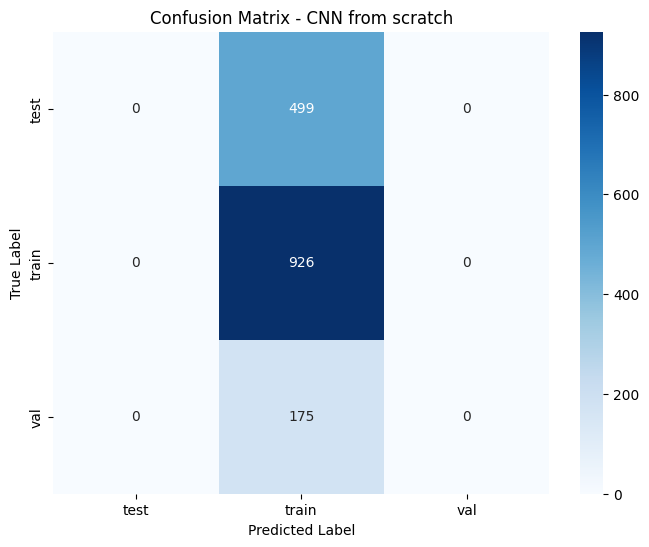


VGG16:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


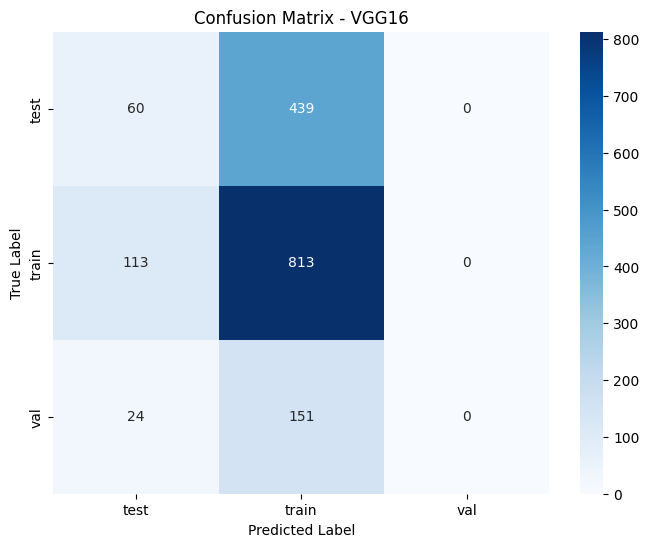


ResNet50:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


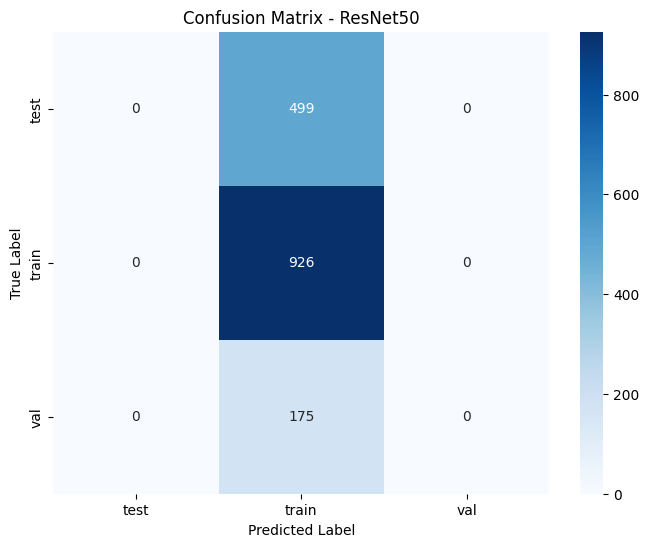


MobileNet:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/

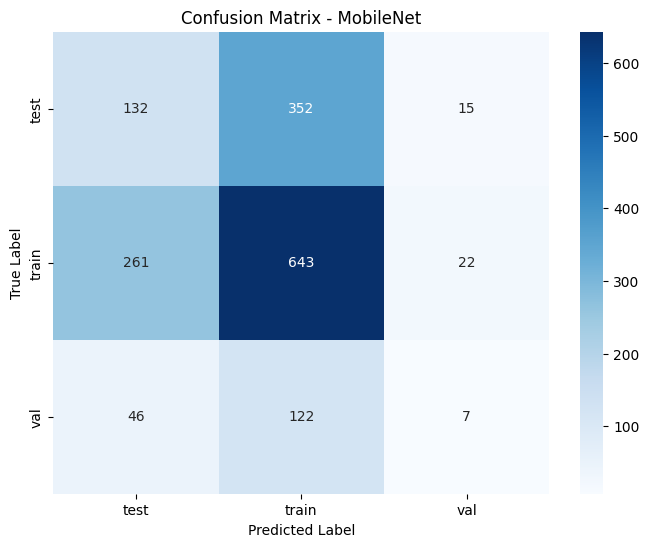


InceptionV3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


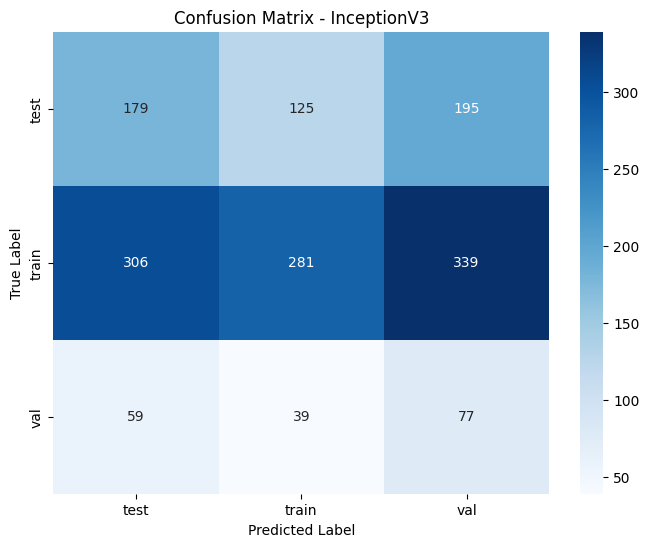


EfficientNetB0:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/st

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


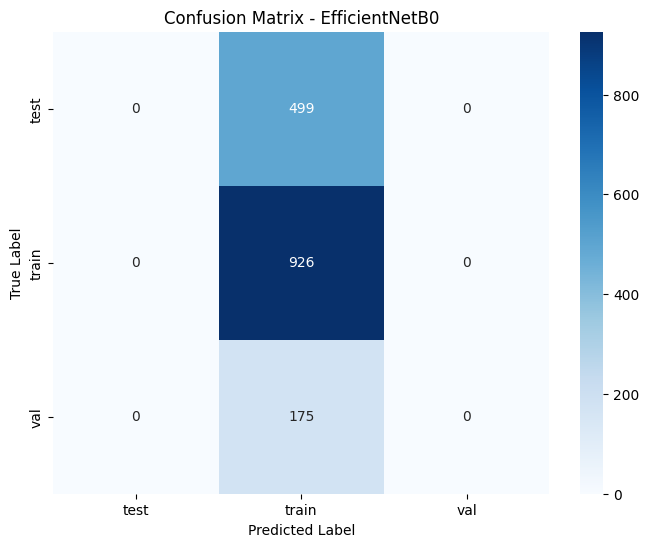


Visualizing training history...


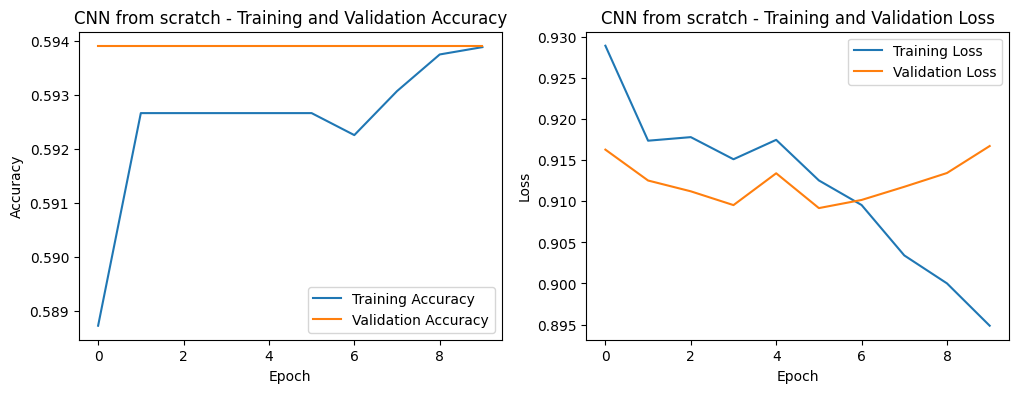

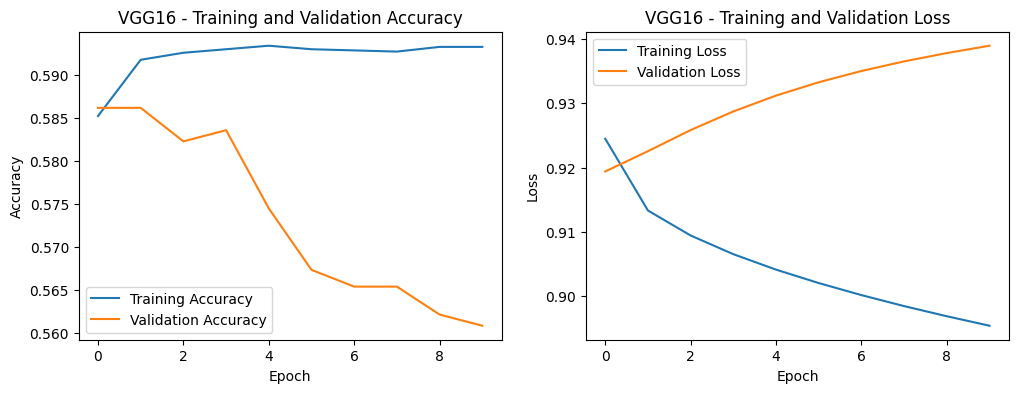

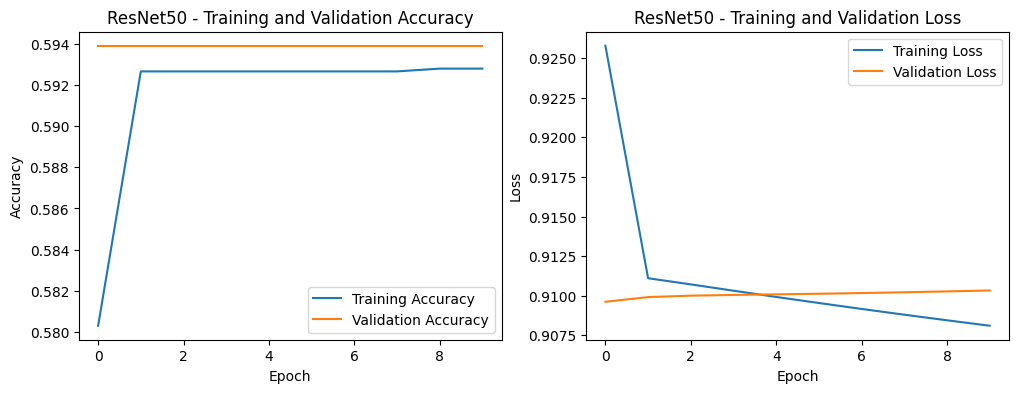

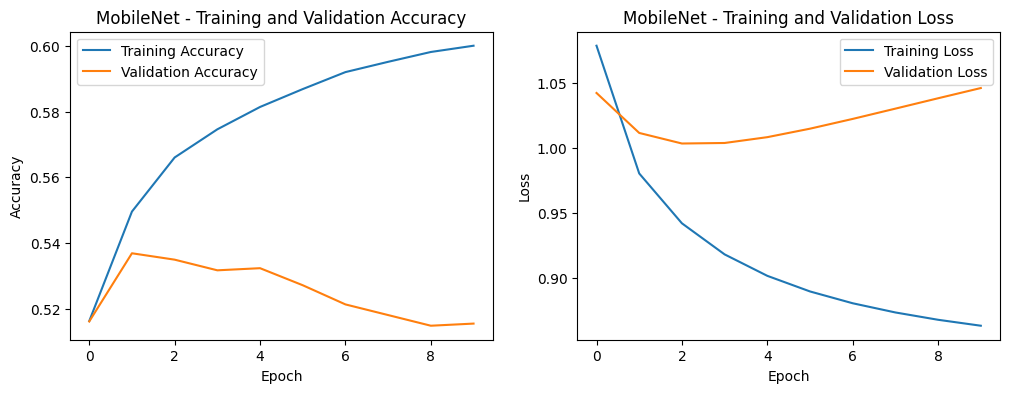

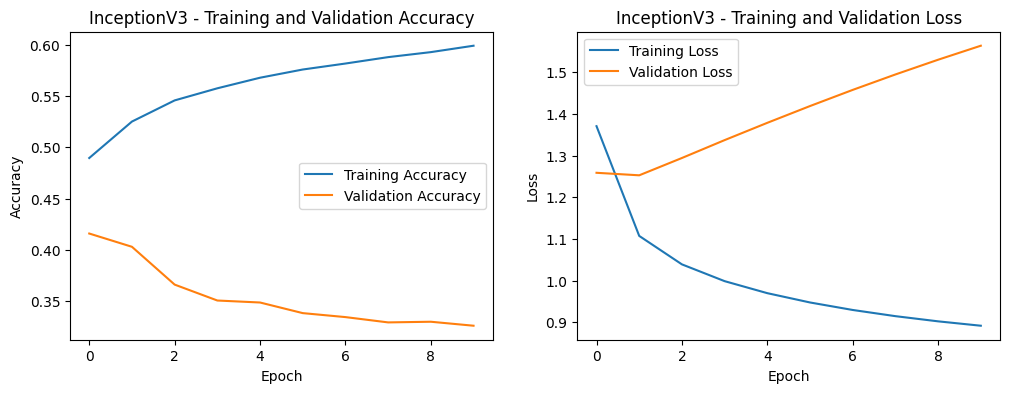

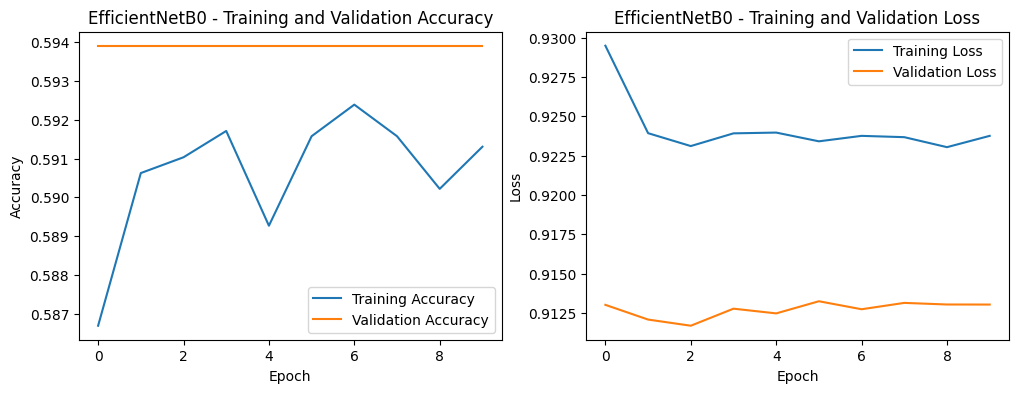


Best performing model based on test accuracy: CNN_from_scratch
Saved the best model to: /content/drive/MyDrive/best_fish_classifier_CNN_from_scratch.h5
Saved class names to: /content/drive/MyDrive/class_names.pkl


In [4]:
# Evaluate all models
print("\nEvaluating models...")
evaluation_results = {}
loss_scratch, accuracy_scratch = model_scratch.evaluate(test_dataset)
evaluation_results['CNN_from_scratch'] = {'loss': loss_scratch, 'accuracy': accuracy_scratch}

for name, model in models.items():
    loss, accuracy = model.evaluate(test_dataset)
    evaluation_results[name] = {'loss': loss, 'accuracy': accuracy}

print("\nEvaluation Results:")
for name, results in evaluation_results.items():
    print(f"{name}:\n Loss: {results['loss']:.4f}\n Accuracy: {results['accuracy']:.4f}")

# Function to get true labels and predictions
def get_labels_and_predictions(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(model.predict(images), axis=-1))
    return np.array(y_true), np.array(y_pred)

# Generate classification reports and confusion matrices for all models
print("\nClassification Reports and Confusion Matrices:")

# CNN from scratch
print("\nCNN from scratch:")
y_true_scratch, y_pred_scratch = get_labels_and_predictions(model_scratch, test_dataset)
print(classification_report(y_true_scratch, y_pred_scratch, target_names=class_names))
cm_scratch = confusion_matrix(y_true_scratch, y_pred_scratch)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_scratch, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - CNN from scratch')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Pre-trained models
for name, model in models.items():
    print(f"\n{name}:")
    y_true_pretrained, y_pred_pretrained = get_labels_and_predictions(model, test_dataset)
    print(classification_report(y_true_pretrained, y_pred_pretrained, target_names=class_names))
    cm_pretrained = confusion_matrix(y_true_pretrained, y_pred_pretrained)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_pretrained, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Visualize training history for all models
print("\nVisualizing training history...")
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history_scratch, 'CNN from scratch')
for name, history in history_pretrained.items():
    plot_training_history(history, name)

# Save the best performing model
best_model_name = 'CNN_from_scratch'
best_accuracy = evaluation_results['CNN_from_scratch']['accuracy']
best_model = model_scratch
for name, results in evaluation_results.items():
    if name != 'CNN_from_scratch' and results['accuracy'] > best_accuracy:
        best_accuracy = results['accuracy']
        best_model_name = name
        best_model = models[name]
print(f"\nBest performing model based on test accuracy: {best_model_name}")

best_model_path = f'/content/drive/MyDrive/best_fish_classifier_{best_model_name}.h5'
best_model.save(best_model_path)
print(f"Saved the best model to: {best_model_path}")

class_names_path = '/content/drive/MyDrive/class_names.pkl'
with open(class_names_path, 'wb') as f:
    pickle.dump(class_names, f)
print(f"Saved class names to: {class_names_path}")

5. Streamlit Deployment Application

###This final block creates a Streamlit application file to deploy the best-performing model.

In [5]:
# Create a Streamlit app file
streamlit_app_code = f"""
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import pickle

# Load the trained model and class names
model_path = '/content/drive/MyDrive/best_fish_classifier_{best_model_name}.h5'
try:
    model = load_model(model_path)
except Exception as e:
    st.error(f"Error loading model: {{e}}")
    st.stop()

class_names_path = '/content/drive/MyDrive/class_names.pkl'
try:
    with open(class_names_path, 'rb') as f:
        class_names = pickle.load(f)
except Exception as e:
    st.error(f"Error loading class names: {{e}}")
    st.stop()

# Define image size
IMG_WIDTH = 128
IMG_HEIGHT = 128

st.title("Fish Image Classification")
st.write("Upload an image of a fish to classify it.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image.", use_column_width=True)

    # Preprocess the image for prediction
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image_array = np.array(image)
    if image_array.shape[-1] != 3:
        image_array = np.stack((image_array,)*3, axis=-1)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array.astype('float32') / 255.0

    # Make prediction
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(predictions)

    st.write(f"Prediction: **{{predicted_class_name}}**")
    st.write(f"Confidence: **{{confidence:.2f}}**")
    st.write("---")
    st.write("Model Evaluation (on test set):")
    st.write("Refer to the Colab notebook for detailed evaluation metrics (Accuracy, Precision, Recall, F1-score, Confusion Matrix).")

"""

streamlit_app_path = '/content/streamlit_app.py'
with open(streamlit_app_path, 'w') as f:
    f.write(streamlit_app_code)

print(f"\nCreated Streamlit app file: {streamlit_app_path}")
print("To run the Streamlit app, execute the following in a new cell:")
print(f"!streamlit run {streamlit_app_path} & npx localtunnel --port 8501")


Created Streamlit app file: /content/streamlit_app.py
To run the Streamlit app, execute the following in a new cell:
!streamlit run /content/streamlit_app.py & npx localtunnel --port 8501


##6. Ngrok Setup and Tunneling

###This code block first installs pyngrok and ngrok, then uses your authentication token to set up the tunnel. After that, it runs the Streamlit application and creates a public URL for you to access.

In [7]:
# Install ngrok and pyngrok
!pip install pyngrok

# Authenticate ngrok with your token
!ngrok authtoken 30SBHkCn73dUUJcofl1fckcZs1z_3jWNiAALp1fVuXC2xAFWX

# Use ngrok to create a public tunnel to your Streamlit app
from pyngrok import ngrok
import os
import subprocess

# Kill any existing ngrok tunnels
os.system("killall ngrok")

# Set the port for the Streamlit app
port = 8501

# Start the ngrok tunnel and get the public URL
public_url = ngrok.connect(port).public_url
print(f"Public URL: {public_url}")

# Run the Streamlit app in the background
subprocess.Popen(["streamlit", "run", "/content/streamlit_app.py", "--server.port", str(port)])

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Public URL: https://7ebda045d9e2.ngrok-free.app


<Popen: returncode: None args: ['streamlit', 'run', '/content/streamlit_app....>

#Future Work


##### Future Work

Based on the current project's scope, there are several avenues for future work that could improve the model's performance, enhance the user experience, and expand the project's functionality.

---

### 1. Model and Performance Enhancements

* **Advanced Architectures**: While you've used a good range of models, you could explore more recent or specialized architectures for fine-grained image classification. This might include **Vision Transformers (ViT)** or other state-of-the-art models that could potentially capture more subtle features.
* **Hyperparameter Tuning**: Instead of using default settings, you could perform a systematic search for the best combination of hyperparameters, such as learning rate, batch size, and optimizer settings. Techniques like **grid search** or **random search** could lead to a significant performance boost.
* **Fine-tuning Unfrozen Layers**: Your current approach freezes the base layers of the pre-trained models. A next step could be to **unfreeze the top few convolutional blocks** and train them with a very low learning rate. This "fine-tuning" allows the model to adapt the pre-trained features more specifically to the fish dataset.
* **Ensemble Modeling**: You could combine the predictions of your top-performing models (e.g., MobileNet and EfficientNetB0) to create a more robust and accurate ensemble model.

---

### 2. Dataset Improvements

* **Expand the Dataset**: The model's performance is highly dependent on the quality and size of the dataset. You could collect more images to include a wider variety of fish species, especially those with similar appearances, which would challenge the model and improve its discriminative power.
* **Handle Data Imbalance**: If certain fish species are underrepresented in the dataset, the model might perform poorly on them. Future work could involve techniques to address this imbalance, such as **oversampling** the minority classes or using a weighted loss function.
* **Video Classification**: The project could be extended to classify fish in a video stream. This would involve processing video frames in real-time and could have applications in underwater monitoring or fisheries management.

---

### 3. Deployment and User Experience

* **Mobile Application**: The Streamlit app is a great start, but you could develop a dedicated mobile application (iOS/Android) using frameworks like **TensorFlow Lite**. This would allow for on-device inference, making the classification process faster and more accessible without a server connection.
* **User Feedback Loop**: Implement a feature in the app where users can confirm if a prediction was correct or incorrect. This user feedback could be used to continuously improve and update the model over time.
* **Scalable Deployment**: For a production environment, the Streamlit app could be containerized using **Docker** and deployed on a cloud service like Google Cloud Platform or AWS, allowing it to handle more traffic and scale as needed.
* **Integrated Information**: When a prediction is made, the application could also retrieve and display additional information about the predicted fish, such as its common habitats, conservation status, or a brief description from an external API.